Attempting to load: simulation_results_accel_hm_v2/sim_results_ahm_v2_20250622_134940_summary.csv
File loaded successfully! Shape: (27, 55)
Converting column: history_num_active_users...
  Successfully converted 'history_num_active_users'. Example (first 5 of first row): [100, 113, 137, 163, 193]
Converting column: history_platform_attractiveness...
  Successfully converted 'history_platform_attractiveness'. Example (first 5 of first row): [0.2740087288891736, 0.3335417298940836, 0.4070992102815037, 0.4561200013100415, 0.45957588908261904]
Converting column: history_avg_user_balance...
  Successfully converted 'history_avg_user_balance'. Example (first 5 of first row): [97.70853688784804, 96.31976935830701, 94.93268428022316, 95.31876022091018, 94.11272430948901]

Data types after history conversion attempts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------     

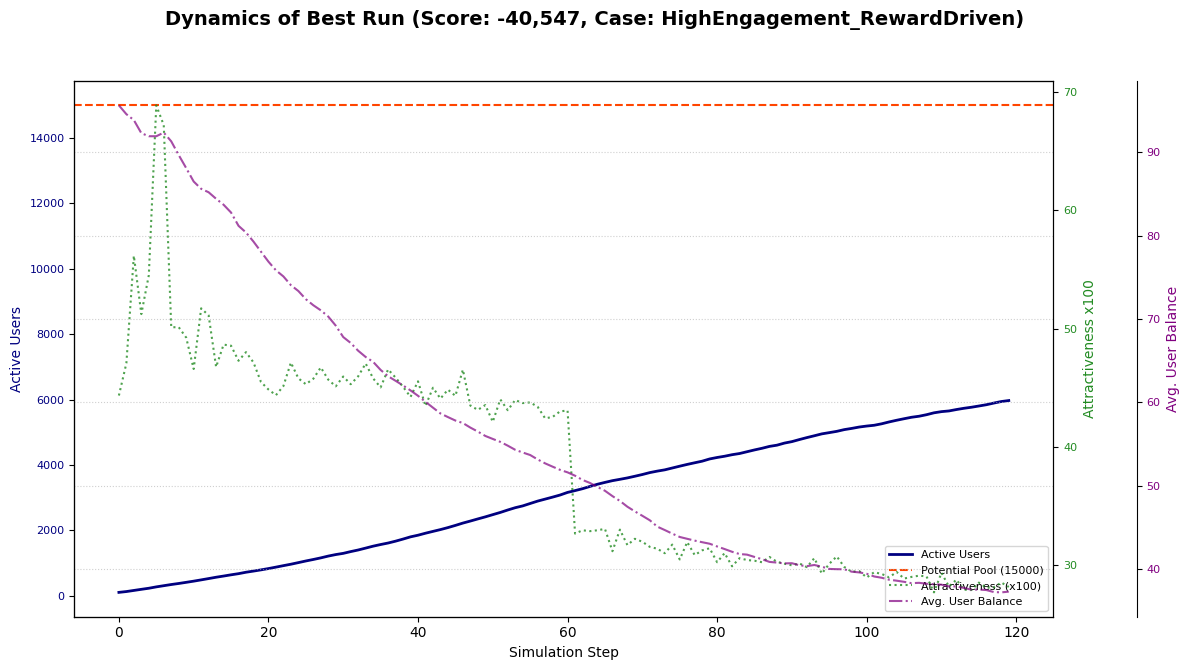

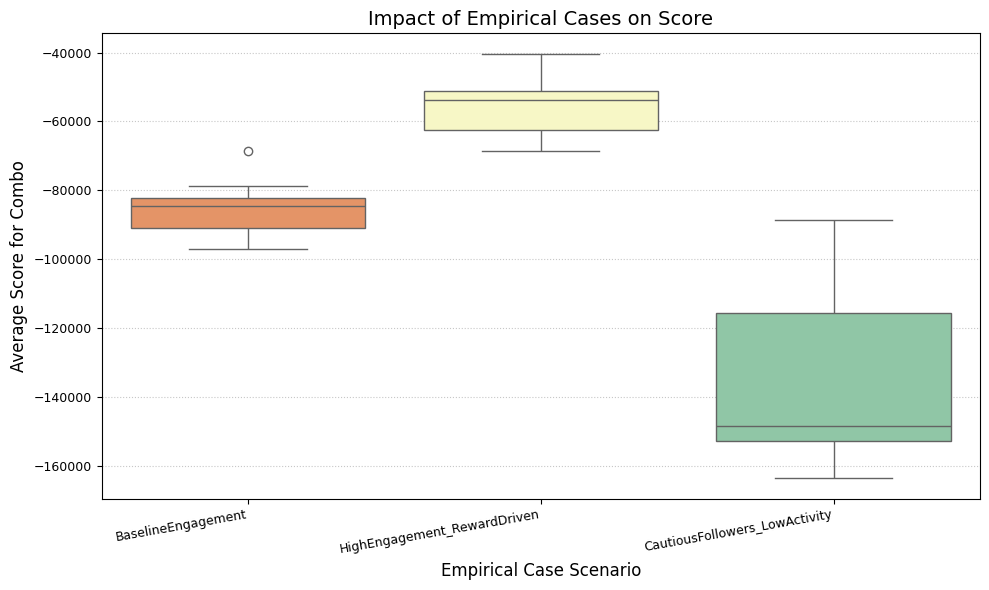


Generating parameter sensitivity plots (faceted by empirical case)...


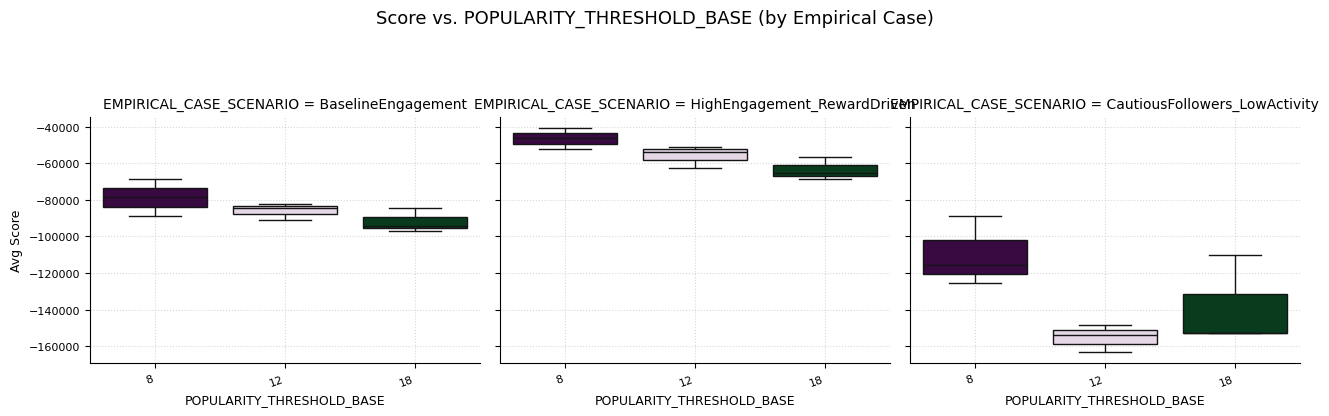

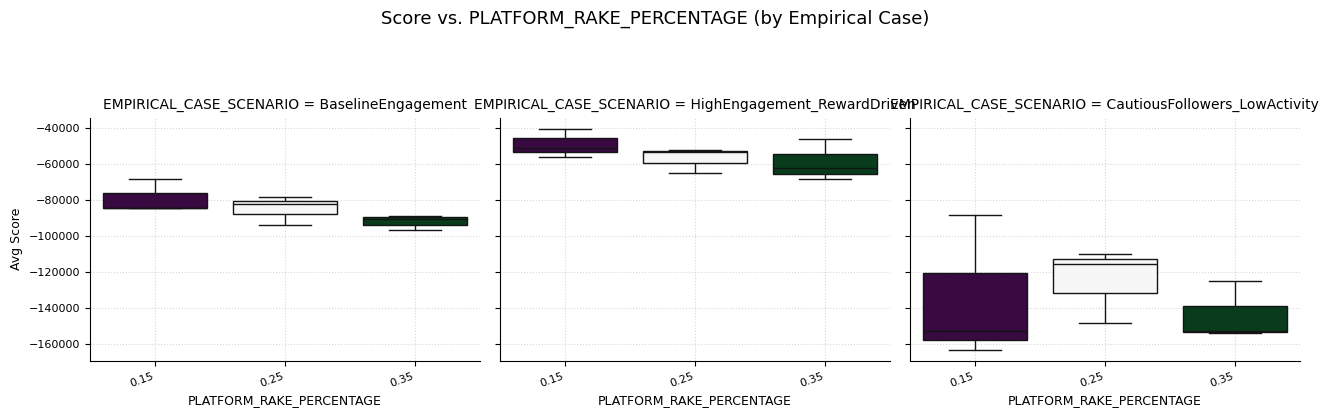

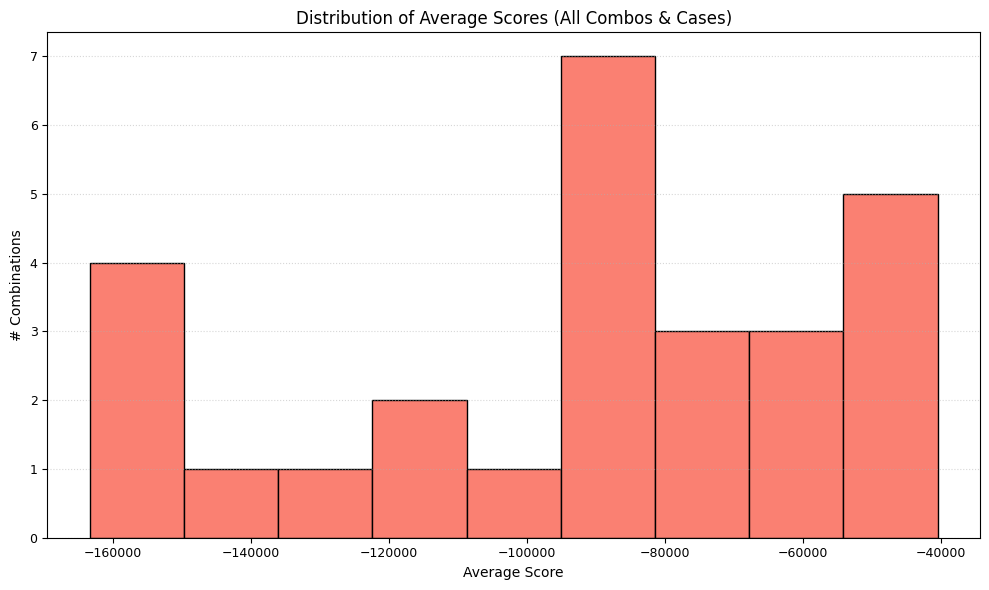


Analysis script finished.


In [11]:
import pandas as pd
import numpy as np
import ast # For safely evaluating string-represented lists/dicts
import re # For regular expressions
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# --- Function to define Empirical Parameter Sets ---
def get_empirical_params_for_case(case_name):
    default_behavioral = {
        'INNOVATOR_PROB_NEW_CONCEPT': 0.60, 'INNOVATOR_PROB_AGREE': 0.30,
        'FOLLOWER_PROB_NEW_CONCEPT': 0.10, 'FOLLOWER_PROB_AGREE': 0.80,
        'BALANCED_PROB_NEW_CONCEPT': 0.35, 'BALANCED_PROB_AGREE': 0.55,
    }
    default_attractiveness = {
        'BASE_ATTRACTIVENESS_NO_USERS': 0.03, 
        'BASE_ATTRACTIVENESS_WITH_USERS': 0.02,
        'ATTRACT_REWARD_SENSITIVITY': 0.3, 
        'ATTRACT_ACTIVITY_SENSITIVITY': 0.4,
        'ATTRACT_FAIRNESS_SENSITIVITY': 0.15, 
        'ATTRACT_BALANCE_SENSITIVITY': 0.2,
    }
    if case_name == "BaselineEngagement":
        params = default_behavioral.copy(); params.update(default_attractiveness)
        params.update({'USER_ARCHETYPES_DIST': {'Innovator': 0.20, 'Follower': 0.65, 'Balanced': 0.15},
                       'FOLLOWER_POPULARITY_BIAS_FACTOR': 2.0, 'USER_ACTIVITY_RATE_ON_PLATFORM': 0.70,})
        return params
    elif case_name == "HighEngagement_RewardDriven":
        params = default_behavioral.copy(); params.update(default_attractiveness)
        params.update({'USER_ARCHETYPES_DIST': {'Innovator': 0.25, 'Follower': 0.55, 'Balanced': 0.20},
                       'FOLLOWER_POPULARITY_BIAS_FACTOR': 1.8, 'USER_ACTIVITY_RATE_ON_PLATFORM': 0.80,
                       'INNOVATOR_PROB_NEW_CONCEPT': 0.65, 'INNOVATOR_PROB_AGREE': 0.25,
                       'FOLLOWER_PROB_NEW_CONCEPT': 0.15, 'FOLLOWER_PROB_AGREE': 0.75,
                       'BALANCED_PROB_NEW_CONCEPT': 0.40, 'BALANCED_PROB_AGREE': 0.50,
                       'BASE_ATTRACTIVENESS_NO_USERS': 0.05, 'BASE_ATTRACTIVENESS_WITH_USERS': 0.03,
                       'ATTRACT_REWARD_SENSITIVITY': 0.5, 'ATTRACT_ACTIVITY_SENSITIVITY': 0.5,
                       'ATTRACT_FAIRNESS_SENSITIVITY': 0.2, 'ATTRACT_BALANCE_SENSITIVITY': 0.3,})
        return params
    elif case_name == "CautiousFollowers_LowActivity":
        params = default_behavioral.copy(); params.update(default_attractiveness)
        params.update({'USER_ARCHETYPES_DIST': {'Innovator': 0.10, 'Follower': 0.75, 'Balanced': 0.15},
                       'FOLLOWER_POPULARITY_BIAS_FACTOR': 2.5, 'USER_ACTIVITY_RATE_ON_PLATFORM': 0.55,
                       'INNOVATOR_PROB_NEW_CONCEPT': 0.50, 'INNOVATOR_PROB_AGREE': 0.40,
                       'FOLLOWER_PROB_NEW_CONCEPT': 0.05, 'FOLLOWER_PROB_AGREE': 0.85,
                       'BALANCED_PROB_NEW_CONCEPT': 0.25, 'BALANCED_PROB_AGREE': 0.65,
                       'BASE_ATTRACTIVENESS_NO_USERS': 0.01, 'BASE_ATTRACTIVENESS_WITH_USERS': 0.005,
                       'ATTRACT_REWARD_SENSITIVITY': 0.2, 'ATTRACT_ACTIVITY_SENSITIVITY': 0.2,
                       'ATTRACT_FAIRNESS_SENSITIVITY': 0.1, 'ATTRACT_BALANCE_SENSITIVITY': 0.1,})
        return params
    else: return get_empirical_params_for_case("BaselineEngagement")

# --- Robust Literal Eval for History Columns ---
def robust_literal_eval_histories(val):
    if not isinstance(val, str): return val
    s = str(val)
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)
    s = re.sub(r'numpy\.float64\(([^)]+)\)', r'\1', s)
    if s.startswith("np.array([") and s.endswith("])"): s = s[len("np.array(["):-len("])")]
    elif s.startswith("numpy.array([") and s.endswith("])"): s = s[len("numpy.array(["):-len("])")]
    s = s.replace('nan', 'None').replace('inf', 'None').replace('-inf', 'None')
    s = re.sub(r',\s*\]', ']', s); s = re.sub(r',\s*\}\)', '})', s)
    try: return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        if s.strip().startswith('[') and s.strip().endswith(']'):
            try:
                numbers_str = re.findall(r"[-+]?\d*\.\d*(?:[eE][-+]?\d+)?|\b[-+]?\d+\b", s)
                return [float(n) for n in numbers_str]
            except: return []
        return []

# --- 1. Load and Prepare Data ---
# !!! IMPORTANT: Update this file_path to your actual CSV file !!!
file_path = "simulation_results_accel_hm_v2/sim_results_ahm_v2_20250622_134940_summary.csv" 

print(f"Attempting to load: {file_path}")

try:
    df_results = pd.read_csv(file_path)
    print("File loaded successfully! Shape:", df_results.shape)
    df = df_results.copy()

    # --- DEFINE MANAGERIAL PARAMS VARIED IN THE SIMULATION RUN ---
    # This MUST match the managerial_params_grid from the sim.py that generated the CSV
    managerial_params_grid_from_sim = {
        'POPULARITY_THRESHOLD_BASE': [8, 12, 18],
        'PLATFORM_RAKE_PERCENTAGE': [0.15, 0.25, 0.35],
        # Add other keys if they were varied in that specific 27-combo sim.py run
        # e.g. 'COST_AGREE_OR_RESUBMIT': [2, 4], 
    }
    # This creates 3*3=9 managerial combos. 9 * 3 empirical cases = 27 total rows. This matches your CSV.
    key_input_params_varied = [k for k, v_list in managerial_params_grid_from_sim.items() if isinstance(v_list, list) and len(v_list) > 1]


    # --- Convert History Columns ---
    history_cols_to_convert = ['history_num_active_users', 'history_platform_attractiveness', 'history_avg_user_balance']
    for col in history_cols_to_convert:
        if col in df.columns:
            print(f"Converting column: {col}...")
            df[col] = df[col].apply(robust_literal_eval_histories)
            # Verification
            if not df[col].empty and isinstance(df[col].iloc[0], list) and df[col].iloc[0]: # check if list and not empty
                 print(f"  Successfully converted '{col}'. Example (first 5 of first row): {df[col].iloc[0][:5]}")
            elif not df[col].empty:
                 print(f"  Warning: Column '{col}' first element is not a list or is empty after conversion. Type: {type(df[col].iloc[0])}, Value: {df[col].iloc[0]}")
            else:
                 print(f"  Column '{col}' is empty.")


    print("\nData types after history conversion attempts:")
    df[history_cols_to_convert].info()

    # --- 2. Define Key Metrics & Identify Top Performers ---
    df_sorted = df.sort_values(by='avg_score_for_combo', ascending=False)

    print("\nTop 5 Performing Combinations (based on avg_score_for_combo):")
    key_output_metrics = ['avg_score_for_combo', 'final_num_active_users', 'users_broke_percent', 
                          'final_treasury', 'final_gini_coefficient', 
                          'avg_actions_per_active_user_per_step_overall', 'EMPIRICAL_CASE_SCENARIO']
    # Ensure key_input_params_varied only contains columns that actually exist in df_sorted
    valid_key_input_params_varied = [p for p in key_input_params_varied if p in df_sorted.columns]
    print(df_sorted[valid_key_input_params_varied + key_output_metrics].head(5))

    best_combo_details_row = df_sorted.iloc[0] if not df_sorted.empty else None
    
    if best_combo_details_row is not None:
        print("\nDetails of the #1 Best Combination:")
        best_combo_dict = best_combo_details_row.to_dict()
        # Print varied managerial params for the best combo
        for k_varied in valid_key_input_params_varied:
            if k_varied in best_combo_dict:
                print(f"  {k_varied}: {best_combo_dict[k_varied]}")
        # Print key output metrics for the best combo
        for k_out in key_output_metrics:
            if k_out in best_combo_dict:
                 val = best_combo_dict[k_out]
                 if isinstance(val, float): print(f"  {k_out}: {val:,.2f}")
                 else: print(f"  {k_out}: {val}")
    else:
        print("No data to determine the best combination.")


    # --- 3. Analyze Robustness Across Empirical Cases ---
    if not df.empty and valid_key_input_params_varied: # Use valid_key_input_params_varied
        print("\nPerformance across Empirical Cases for Top Managerial Settings:")
        df['managerial_combo_id_str'] = df[valid_key_input_params_varied].astype(str).agg('_'.join, axis=1)
        
        grouped_by_managerial = df.groupby('managerial_combo_id_str')
        robustness_summary = []
        for name, group in grouped_by_managerial:
            managerial_params_this_group = group[valid_key_input_params_varied].iloc[0].to_dict()
            robustness_summary.append({
                'managerial_params_str': name,
                'managerial_params_dict': managerial_params_this_group,
                'avg_score_all_cases': group['avg_score_for_combo'].mean(),
                'std_dev_score_all_cases': group['avg_score_for_combo'].std(),
                'min_score_any_case': group['avg_score_for_combo'].min(),
                'max_score_any_case': group['avg_score_for_combo'].max(),
                'num_empirical_cases_tested': group['EMPIRICAL_CASE_SCENARIO'].nunique()
            })
        
        df_robustness = pd.DataFrame(robustness_summary).sort_values(by='avg_score_all_cases', ascending=False)
        print("\nTop Robust Managerial Combinations (High Avg Score across Empirical Cases):")
        print(df_robustness[['managerial_params_str', 'avg_score_all_cases', 'std_dev_score_all_cases', 'min_score_any_case']].head())
    else:
        print("DataFrame is empty or no varied managerial parameters identified, skipping robustness analysis.")

    # --- 4. Visual Analysis ---
    # (Plotting code from previous script, ensure best_combo_details_row is used)
    if best_combo_details_row is not None and \
       'history_num_active_users' in best_combo_details_row and \
       isinstance(best_combo_details_row['history_num_active_users'], list) and \
       best_combo_details_row['history_num_active_users']:
        
        print("\nGenerating plot for the best overall run...")
        potential_pool = best_combo_details_row.get('POTENTIAL_USER_POOL_SIZE', df['POTENTIAL_USER_POOL_SIZE'].iloc[0])
        history_active = best_combo_details_row['history_num_active_users']
        history_attract = best_combo_details_row.get('history_platform_attractiveness', [])
        history_avg_bal = best_combo_details_row.get('history_avg_user_balance', [])

        fig_best, ax_best_active = plt.subplots(figsize=(12,7))
        color1 = 'navy'; ax_best_active.set_xlabel('Simulation Step', fontsize=10)
        ax_best_active.set_ylabel('Active Users', color=color1, fontsize=10)
        ax_best_active.plot(history_active, color=color1, label='Active Users', linewidth=2)
        ax_best_active.tick_params(axis='y', labelcolor=color1, labelsize=8)
        ax_best_active.axhline(y=potential_pool, color='orangered', linestyle='--', label=f'Potential Pool ({potential_pool})')
        ax_best_attract = ax_best_active.twinx()
        color2 = 'forestgreen'
        if isinstance(history_attract, list) and history_attract:
             ax_best_attract.plot(np.array(history_attract) * 100, color=color2, linestyle=':', alpha=0.8, label='Attractiveness (x100)')
        ax_best_attract.set_ylabel('Attractiveness x100', color=color2, fontsize=10); ax_best_attract.tick_params(axis='y', labelcolor=color2, labelsize=8)
        ax_best_avg_bal = ax_best_active.twinx(); ax_best_avg_bal.spines["right"].set_position(("outward", 60)); color3 = 'purple'
        if isinstance(history_avg_bal, list) and history_avg_bal:
            ax_best_avg_bal.plot(history_avg_bal, color=color3, linestyle='-.', alpha=0.7, label='Avg. User Balance')
        ax_best_avg_bal.set_ylabel('Avg. User Balance', color=color3, fontsize=10); ax_best_avg_bal.tick_params(axis='y', labelcolor=color3, labelsize=8)
        current_best_score_val = best_combo_details_row['avg_score_for_combo']
        current_best_case_val = best_combo_details_row['EMPIRICAL_CASE_SCENARIO']
        fig_best.suptitle(f"Dynamics of Best Run (Score: {current_best_score_val:,.0f}, Case: {current_best_case_val})", fontsize=14, fontweight='bold')
        lines1, labels1 = ax_best_active.get_legend_handles_labels(); lines2_twin, labels2_twin = ax_best_attract.get_legend_handles_labels()
        lines3_twin, labels3_twin = ax_best_avg_bal.get_legend_handles_labels()
        all_lines = lines1 + lines2_twin + lines3_twin
        all_labels = labels1 + labels2_twin + labels3_twin
        # Filter out empty labels to prevent legend errors
        valid_legend_items = [(line, label) for line, label in zip(all_lines, all_labels) if label]
        if valid_legend_items:
            valid_lines, valid_labels = zip(*valid_legend_items)
            ax_best_active.legend(valid_lines, valid_labels, loc='best', fontsize=8)

        plt.grid(True, linestyle=':', alpha=0.6); fig_best.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    else:
        print("Could not plot best run history: data missing, not a list, or empty list.")

    if not df.empty:
        if 'EMPIRICAL_CASE_SCENARIO' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='EMPIRICAL_CASE_SCENARIO', y='avg_score_for_combo', data=df, palette="Spectral", hue='EMPIRICAL_CASE_SCENARIO', legend=False)
            plt.title("Impact of Empirical Cases on Score", fontsize=14)
            plt.xlabel("Empirical Case Scenario", fontsize=12); plt.ylabel("Average Score for Combo", fontsize=12)
            plt.xticks(rotation=10, ha='right', fontsize=9); plt.yticks(fontsize=9); plt.grid(axis='y', linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()

        if valid_key_input_params_varied: # Use the validated list
            print("\nGenerating parameter sensitivity plots (faceted by empirical case)...")
            empirical_cases_tested_list_unique = df['EMPIRICAL_CASE_SCENARIO'].unique()
            for param_name in valid_key_input_params_varied:
                if param_name in df.columns and df[param_name].nunique() > 1:
                    try:
                        g = sns.catplot(x=param_name, y='avg_score_for_combo', 
                                        data=df, col='EMPIRICAL_CASE_SCENARIO', 
                                        kind="box", palette="PRGn", sharey=True, 
                                        col_wrap=min(3, len(empirical_cases_tested_list_unique)),
                                        height=4, aspect=1.1, hue=param_name, legend=False) # Added hue and legend=False
                        g.fig.suptitle(f"Score vs. {param_name} (by Empirical Case)", fontsize=13, y=1.03)
                        g.set_xticklabels(rotation=20, ha='right', fontsize=8)
                        g.set_ylabels("Avg Score", fontsize=9); g.set_xlabels(param_name, fontsize=9)
                        for ax_g_cat in g.axes.flatten():
                            ax_g_cat.tick_params(labelsize=8)
                            ax_g_cat.grid(True, linestyle=':', alpha=0.5)
                        plt.tight_layout(rect=[0,0,1,0.93])
                        plt.show()
                    except Exception as e_catplot_detail:
                        print(f"Could not generate catplot for {param_name}: {e_catplot_detail}")
            
            plt.figure(figsize=(10,6))
            scores_hist_vals = [s for s in df['avg_score_for_combo'].dropna() if np.isfinite(s)]
            if scores_hist_vals:
                plt.hist(scores_hist_vals, 
                         bins=max(8, len(df)//3 if len(df)>0 else 1), 
                         edgecolor='black', color='salmon')
                plt.title('Distribution of Average Scores (All Combos & Cases)', fontsize=12)
                plt.xlabel('Average Score', fontsize=10); plt.ylabel('# Combinations', fontsize=10)
                plt.grid(axis='y', linestyle=':', alpha=0.5); 
                plt.yticks(fontsize=9); plt.xticks(fontsize=9); plt.tight_layout(); plt.show()
            else:
                print("No valid scores for score distribution histogram.")
        else:
            print("No varied managerial parameters to plot sensitivities for, or DataFrame empty.")
    else:
        print("DataFrame is empty. No plots generated.")

    print("\nAnalysis script finished.")

except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please check the path and filename.")
except Exception as e:
    print(f"An unexpected error occurred during analysis: {e}")
    import traceback
    traceback.print_exc()

In [12]:
df_sorted = df_results.sort_values(by='avg_score_for_combo', ascending=False)
print("Top 5 performing combinations:")
print(df_sorted.head())

Top 5 performing combinations:
                                   params_config_copy  final_num_active_users  \
1   {'POTENTIAL_USER_POOL_SIZE': 15000, 'INITIAL_A...                    5973   
7   {'POTENTIAL_USER_POOL_SIZE': 15000, 'INITIAL_A...                    6071   
10  {'POTENTIAL_USER_POOL_SIZE': 15000, 'INITIAL_A...                    4894   
4   {'POTENTIAL_USER_POOL_SIZE': 15000, 'INITIAL_A...                    5532   
13  {'POTENTIAL_USER_POOL_SIZE': 15000, 'INITIAL_A...                    5384   

    final_treasury  total_rewards_paid  final_avg_balance  \
1     96673.200000        51178.717054          37.282247   
7    227194.099999        39146.754214          36.539811   
10    82340.850000        27045.849991          36.791678   
4    153326.500000        40196.951964          36.162611   
13   145568.750000        24998.769781          36.933104   

    final_median_balance  final_gini_coefficient  users_broke_percent  \
1              28.506122                0.